In [1]:
import sys
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

# 定义保存路径
save_dir = '/content/drive/My Drive/cnn_gan_model_directory/'

# 创建目录（如果不存在）
import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 128, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), 100, 1, 1)  # (batch_size, z_dim, 1, 1)
        return self.main(x)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


Mounted at /content/drive


In [2]:
dataset = torchvision.datasets.FashionMNIST(root='./FashionMNIST/',
                       transform=transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize((0.5,), (0.5,))]),
                       download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
D = Discriminator().to(device)
G = Generator().to(device)
optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002)
optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002)
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, device=device)

100%|██████████| 26421880/26421880 [01:08<00:00, 384137.44it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 148674.52it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2782288.61it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21854531.37it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



In [3]:
def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

In [4]:
def train_and_generate_images(G, D, num_rounds=100):
    # 标签定义
    lab_real = torch.ones(64, 1, device=device)
    lab_fake = torch.zeros(64, 1, device=device)
    # 储存生成图像数据
    collect_x_gen = []
    # 储存损失值
    loss_D_list = []
    loss_G_list = []
    # 将数据加载器转换为迭代器
    dataloader_iter = iter(dataloader)
    model_count = 1  # 模型保存次数
    for epoch in range(num_rounds):  # 轮数即生成图片的数量
        for i, data in enumerate(dataloader, 0):
            # STEP 1: 判别器优化步骤
            try:
                x_real, _ = next(dataloader_iter)
            except StopIteration:
                dataloader_iter = iter(dataloader)
                x_real, _ = next(dataloader_iter)

            x_real = x_real.to(device)
            batch_size = x_real.size(0)  # 动态获取批量大小
            lab_real = torch.ones(batch_size, 1, device=device)
            lab_fake = torch.zeros(batch_size, 1, device=device)
            optimizerD.zero_grad()
            D_x = D(x_real)
            lossD_real = criterion(D_x, lab_real)
            z = torch.randn(batch_size, 100, device=device)  # 随机噪声，64个样本，z_dim=100
            x_gen = G(z).detach()
            D_G_z = D(x_gen)
            lossD_fake = criterion(D_G_z, lab_fake)
            lossD = lossD_real + lossD_fake
            lossD.backward()
            optimizerD.step()
            # STEP 2: 生成器优化步骤
            optimizerG.zero_grad()
            z = torch.randn(batch_size, 100, device=device)  # 随机噪声，64个样本，z_dim=100
            x_gen = G(z)
            D_G_z = D(x_gen)
            lossG = criterion(D_G_z, lab_real)  # -log D(G(z))
            lossG.backward()
            optimizerG.step()

        loss_D_list.append(lossD.item())
        loss_G_list.append(lossG.item())
        print(epoch, lossD.item(), lossG.item())
        G_path = os.path.join(save_dir, f'generator_{model_count}.pth')
        torch.save(G.state_dict(), G_path)
        G.eval()
        with torch.no_grad():
          x_gen = G(fixed_noise)
        show_imgs(x_gen, new_fig=False)

        model_count += 1

    return loss_D_list, loss_G_list

0 0.4123688042163849 4.156048774719238
1 0.3249798119068146 2.55483078956604
2 0.5221973061561584 2.2029244899749756
3 1.0062825679779053 2.0746517181396484
4 0.7035878896713257 2.094545602798462
5 1.0428283214569092 1.3928048610687256
6 0.9673513770103455 1.4808367490768433
7 1.2396403551101685 1.4975335597991943
8 0.7794915437698364 2.7404544353485107
9 0.7728369235992432 1.7938700914382935
10 0.9280862808227539 1.3394778966903687
11 0.6190657615661621 1.3887860774993896
12 0.8155062198638916 1.2983952760696411
13 1.0206152200698853 1.3432815074920654
14 1.0805656909942627 0.942846417427063
15 0.990212082862854 1.7409465312957764
16 0.970827579498291 1.1210415363311768
17 1.000324010848999 1.3832637071609497
18 1.144747257232666 2.0298218727111816
19 0.9444786906242371 1.4515068531036377
20 1.31424880027771 1.389744520187378
21 0.8273922204971313 1.6438578367233276
22 0.8606005311012268 0.9145059585571289
23 1.5525864362716675 1.464102864265442
24 1.0555698871612549 1.420613050460815

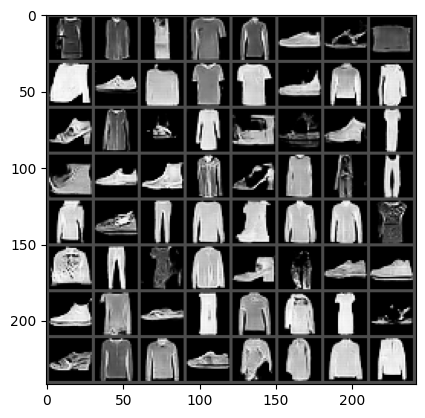

In [5]:
loss_D_list, loss_G_list = train_and_generate_images(G, D)

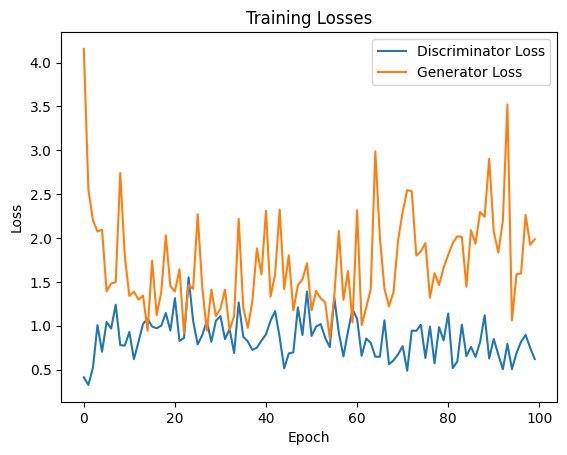

In [6]:
plt.plot(loss_D_list, label="Discriminator Loss")
plt.plot(loss_G_list, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()
plt.show()